### Setup

In [1]:
using Pkg

Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

#Ready to go scripts for each algorithm also avalaible



#Try Pkg.instantiate() if package issues arise




In [2]:
using Dragoon

#number of discs in the booster
n = 20

#initial disc configuration
#findpeak finds an equidistant configuration with a peak at f (see src-->utilities.jl in Dragoon.jl repo for definition)
initdist = findpeak(22.025e9,n)

#generate frequencies for calculation and for plotting
freqs = genFreqs(22.025e9,50e6; length=10) #optimize on these frequencies. Length parameter might not be sufficient at 10 for all frequencies
freqsplot = genFreqs(22.025e9,150e6; length=1000)

#initialize physical properties of the booster
#set to PhysicalBooster if using physical hardware instead of simulated booster
#Definition in src-->types.jl
booster = AnalyticalBooster(initdist)
booster.tand = 0.
#=
Booster(
    pos,              disc positions
    ndisk,            disc number
    thickness,        disc thickness
    epsilon,          disc epsilon
    vmotor,           motor speed
    maxlength,        maximum allowed booster length 
    timestamp,        booster operation time
    summedtraveltime, summed motor operation time
    codetimestamp     code runtime
)
=#

#initialize storage of measurements
hist = initHist(booster,10000,freqs,ObjAnalytical)
#                           ^ length, should be at least n
;

Objective Value: -243.3, Timestamp: 2023-06-19T08:40:37.862


### Optimizer

In [3]:
#=
how to use

neldermead(                     directly modifies booster.pos
    booster,                    
    hist,                       
    freqs,                      frequency range to optimize on
    α,                          reflection parameter, 1 recommended
    β,                          expansion parameter, 1+2/n recommended
    γ,                          contraction parameter, 0.75-1/2n recommended
    δ,                          shrink parameter, 1-1/n recommended
    (objective,[options]),      objective function. Defined in objectivefunctions.jl. Runs the 1D algorithm on the distances updated by the algorithm
    (initsimplex,[options]),    constructs initial simplex
    (simplexobj,[options]),     sweeps all vertices for their objective value
    (unstuckinator,[options]);  tries to unstuck system from bad local minima. See unstuckinators.jl for different methods avalaible
    ϵgrad=0,                    terminate if norm(gradient) falls below this value,
    maxiter=100,                maximum allowed iterations,
    showtrace=false,            wether to print progress,
    showevery=1,                only print every i iterations,
    unstuckisiter=true,         wether an unstucking iteration counts towards maxiter
                                    warning! can run endlessly if false
    tracecentroid=false,        wether to write the centroid to trace, increases operation time
    traceevery=1,               write only every ith iteration to trace
)

returns trace, access with
trace[iteration].x      simplex disc positions
                .obj    simplex objective values
                .x_     centroid disc position if traced
                .obj_   centroid objective value if traced
                .t      timestamp
                .T      summed travel time
=#

In [3]:
trace = nelderMead(booster,hist,freqs,
                    1.,1+2/n,0.75-1/2n,1-1/n,0., #standard initialization. See eng wikipedia article
                    ObjAnalytical,
                    InitSimplexCoord(1e-4),
                    DefaultSimplexSampler,
                    UnstuckDont;
                    maxiter=Int(1e3),
                    showtrace=true,
                    showevery=100,
                    unstuckisiter=true);

Iter: 100

, timestamp: 2 minutes, 23 seconds
Iter finished. Objective value: -1417.108

Iter: 200, timestamp: 3 minutes, 29 seconds
Iter finished. Objective value: -4613.62

Iter: 300, timestamp: 4 minutes, 32 seconds
Iter finished. Objective value: -12760.172



Iter: 400, timestamp: 5 minutes, 11 seconds
Iter finished. Objective value: -13733.936

Iter: 500, timestamp: 5 minutes, 34 seconds
Iter finished. Objective value: -13867.682

Iter: 600, timestamp: 5 minutes, 43 seconds
Iter finished. Objective value: -14088.231



Iter: 700, timestamp: 5 minutes, 47 seconds
Iter finished. Objective value: -14135.984

Iter: 800, timestamp: 5 minutes, 48 seconds
Iter finished. Objective value: -14161.093

Iter: 900, timestamp: 5 minutes, 50 seconds
Iter finished. Objective value: -14186.297



Iter: 1000, timestamp: 5 minutes, 51 seconds
Iter finished. Objective value: -14211.565

Terminated. Max iterations reached.
Final objective value: -14211.565
Elapsed movement time:  5 minutes, 51 seconds
Summed movement time:   30 minutes, 44 seconds


Elapsed computing time: 1 second, 376 milliseconds

In [4]:
#obtain result, booster is now in optimized position
#pos2dist(booster.pos)     #in distance space
booster.pos               #in position space

20-element Vector{Float64}:
 0.0071104117354328965
 0.015515178080012373
 0.02361755347957437
 0.03178905016495553
 0.03991324064999641
 0.048174950743456825
 0.056452613907255374
 0.06468189274041375
 0.07295034336322337
 0.08115771999132358
 0.08933086614454841
 0.09757745861651922
 0.10579819744583897
 0.11407911100903867
 0.12228173993056626
 0.1305483332032982
 0.13865692815607195
 0.14683160045399876
 0.1548182784390491
 0.16293102979758506

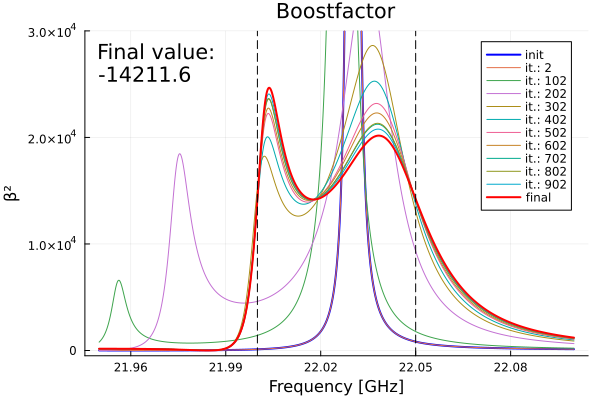

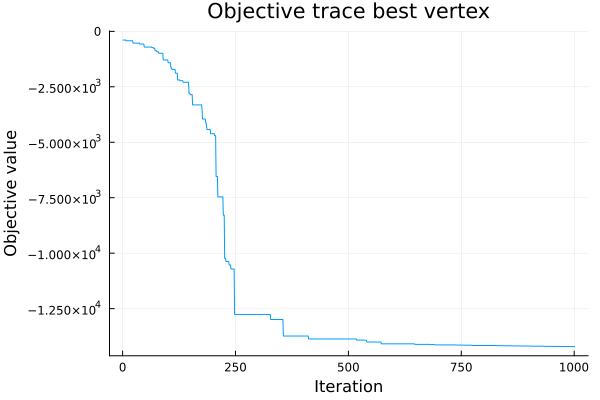

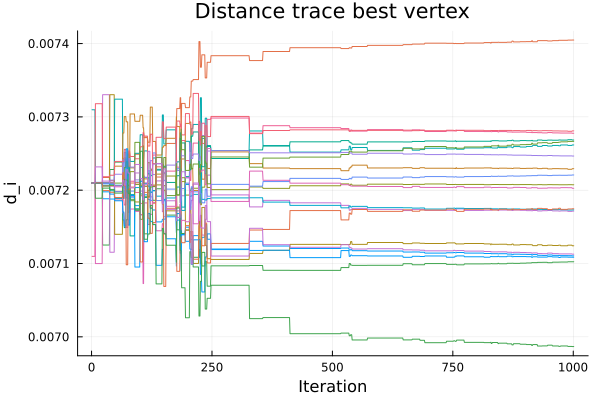

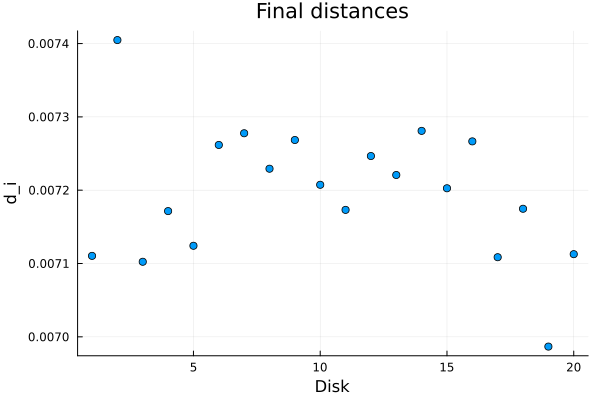

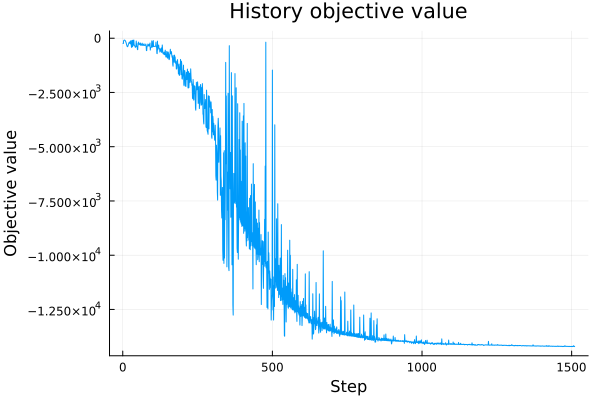

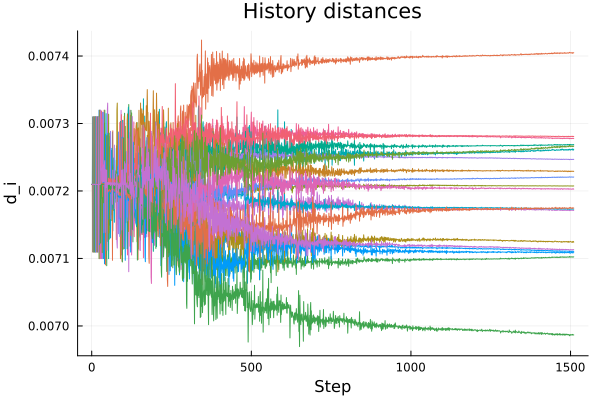

(Plot{Plots.GRBackend() n=13}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=20}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=20})

In [6]:
#get handy output
plt = analyse(hist,trace,freqsplot; freqs=freqs,div=10)

#savefig(plt[i],"cool_epic_result_wow.svg")